## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Computation of the camera calibration using chessboard images

First we need to calibrate the camera using chess board images taken by the same camera. It is imporant to calulate the lane curvature and car positon correclyt. In the cell bellow there is and example of camera calibration with one of the calibration image. 

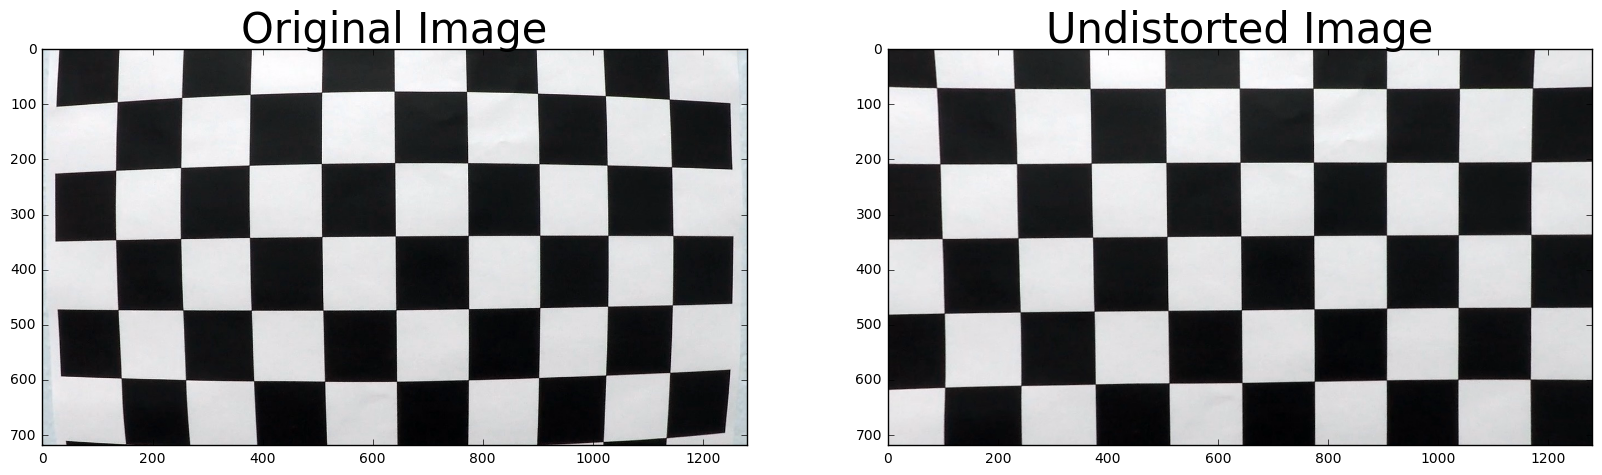

In [2]:
from Camera import Camera
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('camera_cal/calibration1.jpg')
calibration_path = 'camera_cal'
camera  = Camera(calibration_path)
# Test undistortion on an raw calibration image

dst = camera.undistort(img)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Undistortion Example

In the cell bellow there is an example of camera calibration with one of the test image taken from the car camera. 

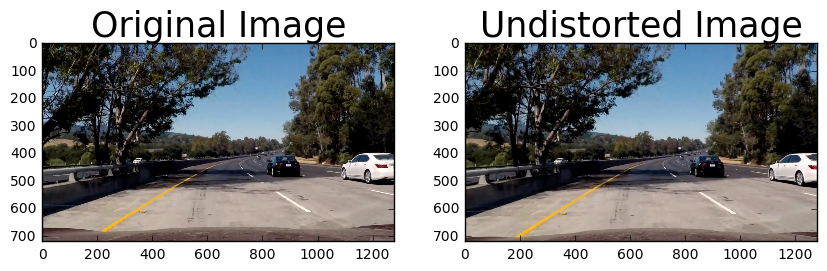

In [18]:
#Test undistortion on an test image
img = plt.imread('test_images/test5.jpg')
figsize=(10,5)
dst = camera.undistort(img)
cv2.imwrite('output_images/test2.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=25)
plt.show()

In the cell bellow there is an example of masking image to mask lane lines. In order to do tham several image processing teqniqques were tested and combine at the and image masked based on the sobel trshold on x direction and image converted to HLS color space and only S component extracted and tresholded. After that bitwise or operation is applied to the masked images. (sobelx and extracred S). In the masked image there are a lot of images seen other than lanes in order to clear them we need to apply perspective transform to get interested area and the image and transfor it to another view to find lane lines and caculate the propecties easily. 

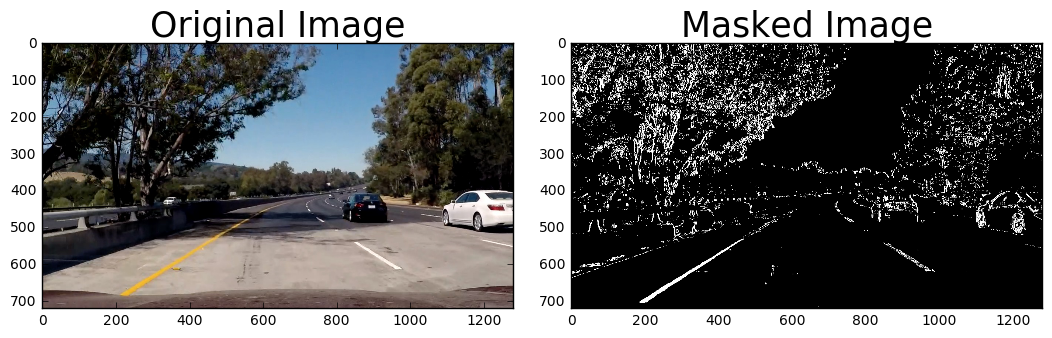

In [19]:
from ImageProcesing import combined_threshold

img = plt.imread('test_images/test5.jpg')

undistorted_image = camera.undistort(img)
combined_image = combined_threshold(undistorted_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Masked Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In the cell bellow there is an example of perpective transform to birdseye view with one of the test image. 

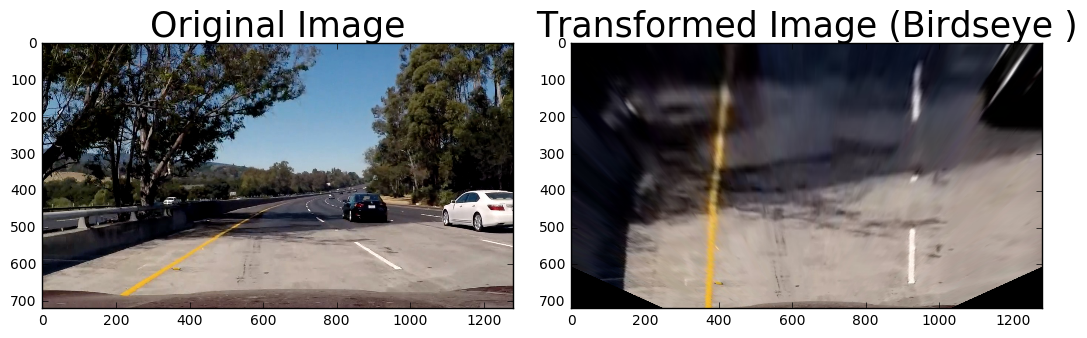

In [21]:
from PerspectiveTransform import PerspectiveTransform
perspectiveTransformer = PerspectiveTransform()
img = plt.imread('test_images/test5.jpg')

undistorted_image = camera.undistort(img)
transformed_image = perspectiveTransformer.get_perpective_transform(undistorted_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(transformed_image, cmap='gray')
ax2.set_title('Transformed Image (Birdseye )', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In the cell bellow you can see and example of output of implemented teqnies so far (camera calibration, perspective trasnfor and lane masking). As seen on the left image still is not perfecly masked there are some noise and non lanes pixels we will deal with that with the Lane detector module to detect only the lanes and put it on the image.  

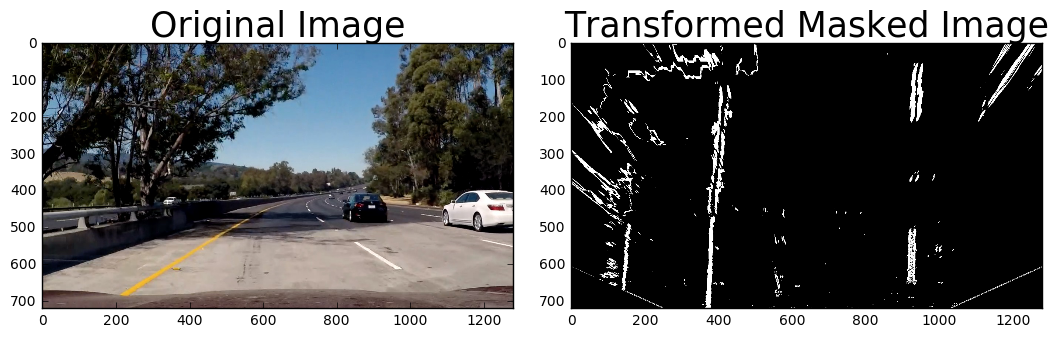

In [22]:
img = plt.imread('test_images/test5.jpg')

undistorted_image = camera.undistort(img)
perspectiveTransformer = PerspectiveTransform()
transformed_image = perspectiveTransformer.get_perpective_transform(undistorted_image)
combined_image = combined_threshold(transformed_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Transformed Masked Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2




    #plt.xlim(0, 1280)
    #plt.ylim(0, 720)
    #plt.plot(left_fitx, ypoints, color='green', linewidth=3)
    #plt.plot(right_fitx, ypoints, color='green', linewidth=3)
    #plt.gca().invert_yaxis() # to visualize as we do the images
    # Draw the results
    #template = np.array(r_points + l_points, np.uint8)  # add both left and right window pixels together
    #zero_channel = np.zeros_like(template)  # create a zero color channle 
    #template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)  # make window pixels green
    #warpage = np.array(cv2.merge((transformed_iamge, transformed_iamge, transformed_iamge)),np.uint8)  # making the original road pixels 3 color channels
    #output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)  # overlay the orignal road image with window results

In [17]:
from scipy import signal
#np.set_printoptions(threshold=np.inf)
class Lane:
    # Frame counter (used for finding new lanes)
    frame_number = 0
    # Lane locations from previous frame
    last_left_x = 0
    last_right_x = 0
    # Lane locations from current frame
    left_x = 0
    right_x = 0
    # Lane persp image
    left_lane_img = 0
    right_lane_img = 0
    # Lane persp debug image
    lane_debug_img = 0
    # Frames since lane last detected
    # Init with large value to trigger full scan
    left_last_seen = 999
    right_last_seen = 999
    # Lane fit coords
    sleft_fitx = 0
    left_fity = 0
    right_fitx = 0
    right_fity = 0
    # Lane radius of curvature
    left_curverad = 0
    right_curverad = 0
    # Lanes found in last frame?
    left_lane_found  = False
    right_lane_found = False
    # Lane polynomial fits
    left_fit = []
    right_fit = []
    # Debug Mode
    debug_mode = False
    # Debug Mode
    show_plots = False
    
    def full_scan(self, hist):
        if self.debug_mode:
            print("Running full scan...")
        num_pixels_x = len(hist)
        left_side = hist[0:int(num_pixels_x/2)]
        left_peak_x = np.argmax(left_side)
        right_side = hist[int(num_pixels_x/2):]
        right_peak_x = np.argmax(right_side)
        right_offset = int(num_pixels_x/2)
        right_peak_x += right_offset
        return left_peak_x, right_peak_x
    
    def get_two_peak_x_coords(self, hist, prev_left_x=-1, prev_right_x=-1, start_y=0, end_y=0, found_last_left=False, found_last_right=False, left_trend=0, right_trend=0):
        num_pixels_x = len(hist)
        left_window = 40 
        right_window = 40 
        found_left = True
        found_right = True

        if not found_last_left:
            left_window = 60
        if not found_last_right:
            right_window = 60
        if start_y == 720:
            left_window = 100 
            right_window = 100 

        left_offset = 0
        if self.left_lane_found:
            new_left_peak = int(self.left_fit[0]*start_y**2 + self.left_fit[1]*start_y + self.left_fit[2])
            if self.debug_mode:
                print("    LEFT USING POLY : {}".format(new_left_peak))
                cv2.rectangle(self.lane_debug_img, (new_left_peak-left_window,start_y), (new_left_peak+left_window, end_y), (0, 255, 0),  thickness=2)
        else:
            left_side = hist[prev_left_x+left_trend-left_window:prev_left_x+left_trend+left_window]
            if self.debug_mode:
                cv2.rectangle(self.lane_debug_img, (prev_left_x+left_trend-left_window,start_y), (prev_left_x+left_trend+left_window, end_y), (255, 0, 0),  thickness=2)
            new_left_peak = 0
            if len(left_side) > 0:
                if self.debug_mode:
                    print("    LEFT MINI SCAN")
                new_left_peak = np.argmax(left_side)
                left_offset = prev_left_x+left_trend - left_window
            if new_left_peak == 0 or len(left_side) == 0:
                if self.debug_mode:
                    print("    LEFT USE PREV")
                new_left_peak = prev_left_x+left_trend
                left_offset = 0
                found_left = False
        left_peak_x = new_left_peak + left_offset
        if self.debug_mode:
            cv2.line(self.lane_debug_img, (left_peak_x, start_y), (left_peak_x, end_y), (0, 255, 255), thickness=2)

        right_offset = 0
        if self.right_lane_found:
            new_right_peak = int(self.right_fit[0]*start_y**2 + self.right_fit[1]*start_y + self.right_fit[2])
            if self.debug_mode:
                print("    RIGHT USING POLY : {}".format(new_right_peak))
                cv2.rectangle(self.lane_debug_img, (new_right_peak-right_window,start_y), (new_right_peak+right_window, end_y), (0, 255, 0),  thickness=2)
        else:
            right_side = hist[prev_right_x+right_trend-right_window:prev_right_x+right_trend+right_window]
            if self.debug_mode:
                cv2.rectangle(self.lane_debug_img, (prev_right_x+right_trend-right_window,start_y), (prev_right_x+right_trend+right_window, end_y), (255, 255, 0),  thickness=2)
            new_right_peak = 0
            if len(right_side) > 0:
                if self.debug_mode:
                    print("    RIGHT MINI SCAN")
                new_right_peak = np.argmax(right_side)
                right_offset = prev_right_x+right_trend - right_window
            if new_right_peak == 0 or len(right_side) == 0:
                if self.debug_mode:
                    print("    RIGHT USE PREV")
                new_right_peak = prev_right_x+right_trend
                right_offset = 0
                found_right = False
        right_peak_x = new_right_peak + right_offset
        if self.debug_mode:
            cv2.line(self.lane_debug_img, (right_peak_x, start_y), (right_peak_x, end_y), (0, 255, 255), thickness=2)

        if start_y == 720:
            new_left_trend = 0
            new_right_trend = 0
        else:
            new_left_trend = left_peak_x - prev_left_x 
            new_right_trend = right_peak_x - prev_right_x
        return left_peak_x, right_peak_x, found_left, found_right, new_left_trend, new_right_trend

    def locate_lanes(self, img):
        #histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        #histogram_smooth = signal.medfilt(histogram, 7)
        #peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 5)))
        #print(' peaks : ',peaks)
        #plt.plot(histogram_smooth)
        #plt.show()
        if self.debug_mode:
            print("Frame # {}".format(self.frame_number))
        # Is this the first frame of video?
        if self.frame_number == 0 or self.left_last_seen > 5 or self.right_last_seen > 5:
            # Generate histogram over bottom half of image
            histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
            # Find X coords of two peaks of histogram
            est_left_x, est_right_x = self.full_scan(histogram)
            if self.debug_mode:
                print("est_left_x : {}, est_right_x : {}".format(est_left_x, est_right_x))
                if self.show_plots:
                    plt.imshow(img)
                    plt.show()
                    plt.plot(histogram)
                    plt.show()
        else:
            est_left_x = self.last_left_x
            est_right_x = self.last_right_x

        fallback_left_x = est_left_x
        fallback_right_x = est_right_x
        left_trend = 0
        right_trend = 0
    
        # Run a sliding window up the image to detect pixels
        self.left_lane_img = np.zeros(img.shape[0:2], np.float32)
        self.right_lane_img = np.zeros(img.shape[0:2], np.float32)
        temp_img = img*255
        self.lane_debug_img = np.dstack((temp_img, temp_img, temp_img))
    
        found_last_left = False
        found_last_right = False
        left_window = 40
        right_window = 40
        left_conc_sections = 0
        right_conc_sections = 0
        for i in range(10, 0, -1):
            start_y = int(i * img.shape[0]/10)
            end_y = int((i-1) * img.shape[0]/10)
            img_sect = img[end_y:start_y,:]
            histogram = np.sum(img_sect, axis=0)
            left_x, right_x, found_last_left, found_last_right, new_left_trend, new_right_trend = self.get_two_peak_x_coords(histogram, est_left_x, est_right_x, start_y, end_y, found_last_left, found_last_right, left_trend, right_trend)
            left_trend = int((new_left_trend + left_trend) / 2)
            right_trend = int((new_right_trend + right_trend) / 2)
            # Store the left/right x values for bottom of image
            if i == 10:
                # Set the new last values
                self.left_x = left_x
                self.right_x = right_x

            if not found_last_left:
                left_x = fallback_left_x
                left_conc_sections = 0
            elif left_conc_sections > 1:
                fallback_left_x = left_x
            if not found_last_right:
                right_x = fallback_right_x
                right_conc_sections = 0
            elif right_conc_sections > 1:
                fallback_right_x = right_x

            if found_last_left:
                left_conc_sections += 1
            if found_last_right:
                right_conc_sections += 1
          
            if self.debug_mode:
                print("i: {} Start_y: {} End_y: {}".format(i, start_y, end_y))
                print("    est_left_x : {}, est_right_x : {}".format(est_left_x, est_right_x))
                print("    left_x : {}, right_x : {}".format(left_x, right_x))
                print("    left_window : {}, right_window : {}".format(left_window, right_window))
                print("    left_trend : {}, right_trend : {}".format(left_trend, right_trend))
                if self.show_plots:
                    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
                    f.tight_layout()
                    ax1.plot(histogram)
                    ax2.imshow(img_sect, cmap='gray')
                    plt.show()
    
            # Fill in the left lane image
            left_mask = np.zeros_like(img_sect)
            left_mask[:,left_x-left_window:left_x+left_window]=1
            mask = (left_mask==1)
            self.left_lane_img[end_y:start_y,:] = img_sect & mask
    
            # Fill in the right lane image
            right_mask = np.zeros_like(img_sect)
            right_mask[:,right_x-right_window:right_x+right_window]=1
            mask = (right_mask==1)
            self.right_lane_img[end_y:start_y,:] = img_sect & mask
    
            # Set the new last values
            est_left_x = left_x
            est_right_x = right_x

        self.frame_number += 1    

    def fit_lane(self, img):
        # Extract the list of x and y coords that are non-zero pixels
        xycoords = np.nonzero(img)
        x_arr = xycoords[1]
        y_arr = xycoords[0]
        
        # Fit a second order polynomial to each fake lane line
        fit = np.polyfit(y_arr, x_arr, deg=2)
        fitx = fit[0]*y_arr**2 + fit[1]*y_arr + fit[2]
    
        # Find RoC in pixel space
        #y_eval = np.max(y_arr)
        #curverad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) \
        #                         /np.absolute(2*fit[0])
    
        # Ensure we have points for min(0) & max(719) y
        # This will extend the lines in cases where the lanes
        # dont have pixels all the way to top/bottom of image
        fitx = np.insert(fitx, 0, fit[0]*0**2 + fit[1]*0 + fit[2])
        fity = np.insert(y_arr, 0, 0)
        fitx = np.append(fitx, fit[0]*719**2 + fit[1]*719 + fit[2])
        fity = np.append(fity, 719)
    
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        y_eval = np.max(y_arr)
        fit_cr = np.polyfit(y_arr*ym_per_pix, x_arr*xm_per_pix, 2)
        fitx_cr = fit_cr[0]*(y_arr*ym_per_pix)**2 + fit_cr[1]*y_arr*ym_per_pix + fit_cr[2]
    
        # Get radius of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])

        return fit, fitx, fity, curverad

    def fit_lanes(self):
        self.left_lane_found = False
        self.right_lane_found = False
        # Get new lane fit for left lane
        left_fit, left_fitx, left_fity, left_curverad = self.fit_lane(self.left_lane_img)
        # Only use this new lane fit if it's close to the previous one (for smoothing)
        if self.frame_number == 1 or self.check_lane(left_curverad, self.left_curverad, self.left_x, self.last_left_x):
            self.left_fit = left_fit
            self.left_fitx = left_fitx
            self.left_fity = left_fity
            self.left_curverad = left_curverad
            self.left_lane_found = True
            self.left_last_seen = 0
            if self.debug_mode:
                print("Frame : {} Left Lane found! RoC : {} Prev X : {} Curr X : {}".format(self.frame_number-1, left_curverad, self.last_left_x, self.left_x))
            self.last_left_x = self.left_x
        else:
            self.left_last_seen += 1
            if self.debug_mode:
                print("Left Lane NOT found! ({})".format(self.left_last_seen))

        # Get new lane fit for right lane
        right_fit, right_fitx, right_fity, right_curverad = self.fit_lane(self.right_lane_img)
        # Only use this new lane fit if it's close to the previous one (for smoothing)
        if self.frame_number == 1 or self.check_lane(right_curverad, self.right_curverad, self.right_x, self.last_right_x):
            self.right_fit = right_fit
            self.right_fitx = right_fitx
            self.right_fity = right_fity
            self.right_curverad = right_curverad
            self.right_lane_found = True
            self.right_last_seen = 0
            if self.debug_mode:
                print("Frame : {} Right Lane found! RoC : {} Prev X : {} Curr X : {}".format(self.frame_number-1, right_curverad, self.last_right_x, self.right_x))
            self.last_right_x = self.right_x
        else:
            self.right_last_seen += 1
            if self.debug_mode:
                print("Right Lane NOT found! ({})".format(self.right_last_seen))


    def draw_lanes(self, img, warped, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.left_fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.right_fity])))])
        pts = np.hstack((pts_left, pts_right))
    
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Draw lane lines only if lane was detected this frame
        if self.left_lane_found == True:
            cv2.polylines(color_warp, np.int_([pts_left]), False, (0,0,255), thickness=20)
        if self.right_lane_found == True:
            cv2.polylines(color_warp, np.int_([pts_right]), False, (255,0,0), thickness=20)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

        # Write the radius of curvature for each lane 
        font = cv2.FONT_HERSHEY_SIMPLEX
        left_roc = "Roc: {0:.2f}m".format(self.left_curverad) 
        cv2.putText(result, left_roc, (10,650), font, 1, (255,255,255), 2)
        right_roc = "Roc: {0:.2f}m".format(self.right_curverad) 
        cv2.putText(result, right_roc, (1020,650), font, 1, (255,255,255), 2)
    
        # Write the x coords for each lane 
        left_coord = "X  : {0:.2f}".format(self.left_x) 
        cv2.putText(result, left_coord, (10,700), font, 1, (255,255,255), 2)
        right_coord = "X  : {0:.2f}".format(self.last_right_x) 
        cv2.putText(result, right_coord, (1020,700), font, 1, (255,255,255), 2)

        # Write dist from center
        perfect_center = 1280/2.
        lane_x = self.last_right_x - self.left_x
        center_x = (lane_x / 2.0) + self.left_x
        cms_per_pixel = 370.0 / lane_x   # US regulation lane width = 3.7m
        dist_from_center = (center_x - perfect_center) * cms_per_pixel
        dist_text = "Dist from Center: {0:.2f} cms".format(dist_from_center)
        cv2.putText(result, dist_text, (450,50), font, 1, (255,255,255), 2)

    
        return result
    
def histogram_lane_detection(img, steps, search_window, h_window):
    """
    Tries to detect lane line pixels by applying a sliding histogram.
    :param img: binary image
    :param steps: steps for the sliding histogram
    :param search_window: Tuple which limits the horizontal search space.
    :param h_window: window size for horizontal histogram smoothing
    :return: x, y of detected pixels
    """
    all_x = []
    all_y = []
    masked_img = img[:, search_window[0]:search_window[1]]
    plt.imshow(masked_img)
    plt.show()
    pixels_per_step = img.shape[0] // steps

    for i in range(steps):
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        histogram = np.sum(masked_img[end:start, :], axis=0)
        histogram_smooth = signal.medfilt(histogram, h_window)
        peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 5)))

        highest_peak = highest_n_peaks(histogram_smooth, peaks, n=1, threshold=5)
        if len(highest_peak) == 1:
            highest_peak = highest_peak[0]
            center = (start + end) // 2
            x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)

            all_x.extend(x)
            all_y.extend(y)

    all_x = np.array(all_x) + search_window[0]
    all_y = np.array(all_y)

    return all_x, all_y

def highest_n_peaks(histogram, peaks, n=2, threshold=0):
    """
    Returns the n highest peaks of a histogram above a given threshold.
    :param histogram:
    :param peaks: list of peak indexes
    :param n: number of peaks to select
    :param threshold:
    :return:
    """
    plt.plot(histogram)
    plt.show()
    print('peaks : ',peaks)
    if len(peaks) == 0:
        return []

    peak_list = [(peak, histogram[peak]) for peak in peaks if histogram[peak] > threshold]
    peak_list = sorted(peak_list, key=lambda x: x[1], reverse=True)

    if len(peak_list) == 0:
        return []

    x, y = zip(*peak_list)
    x = list(x)

    if len(peak_list) < n:
        return x
    print('x : ',x)
    return x[:n]

def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixel inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

def process_image(image): 
    camera = Camera()
    undistorted_image = camera.undistort(image)
    # Plot the result
    binary_image = combined_threshold(undistorted_image)

    pt = PerspectiveTransform()
    transformed_image = pt.get_perpective_transform(binary_image)
    lanes = Lane()
    lanes.locate_lanes(transformed_image)
    # Fit polynomials and set lane x/y arrays
    lanes.fit_lanes()

    # Check curvature sanity

    # Draw lines back onto road
    combined_img = lanes.draw_lanes(undistorted_image, transformed_image, pt.Minv)
    #print('what it is : ', (250, binary_image.shape[1] // 2))
    #x,y = histogram_lane_detection(transformed_image, 10, (250, transformed_image.shape[1] // 2), 7)
    #print(x)
    #print(y)
    #right_x, right_y = histogram_lane_detection(transformed_image, 10, (transformed_image.shape[1]// 2, transformed_image.shape[1] - 250), h_window=7)
    #print(right_x)
    #print(right_y)
    return combined_img

image = mpimg.imread('test_images/test3.jpg')
processed = process_image(image)
processed2 = process_image2(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(processed2,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

ValueError: object too deep for desired array

In [9]:
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip

VIDEOS = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]
white_output = 'willBeDeleted2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image2) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video willBeDeleted2.mp4
[MoviePy] Writing video willBeDeleted2.mp4


100%|█████████▉| 1260/1261 [02:09<00:00,  9.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: willBeDeleted2.mp4 



In [8]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

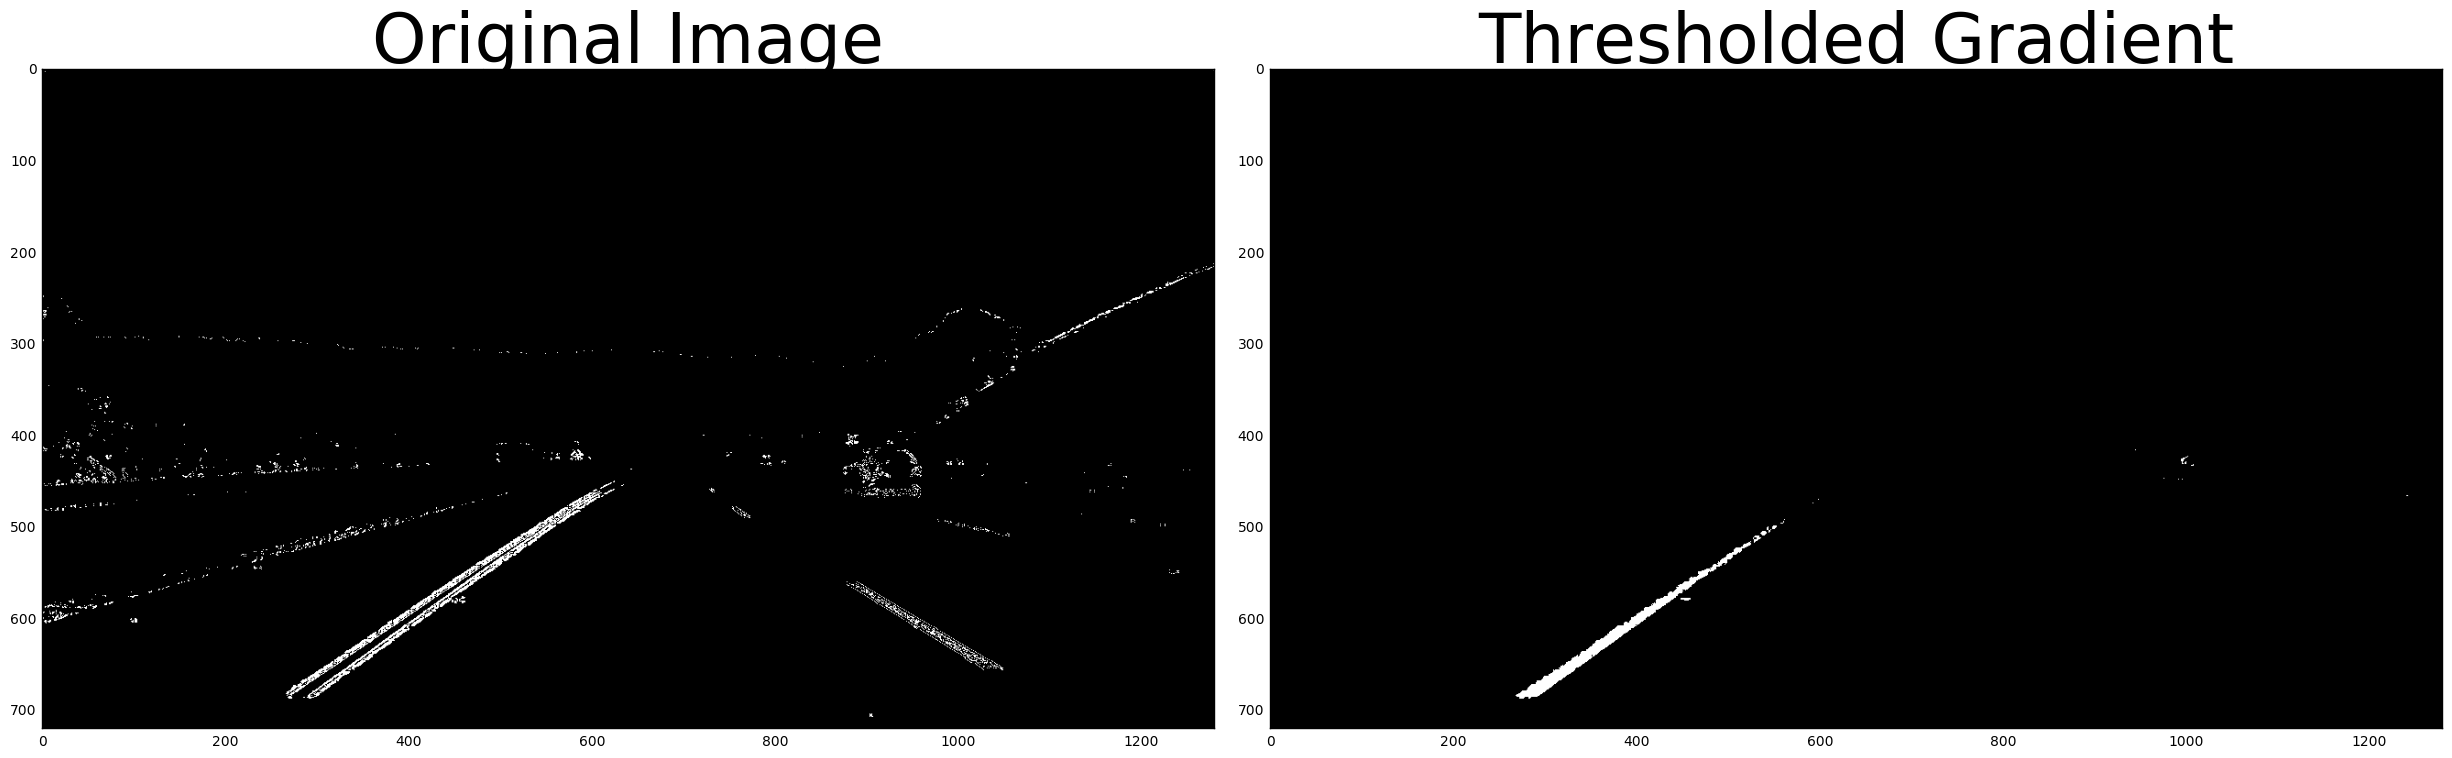

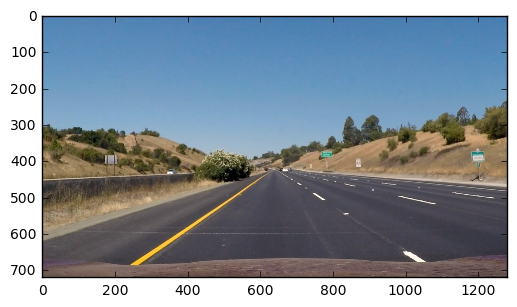

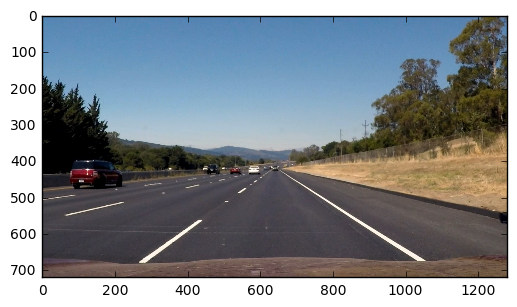

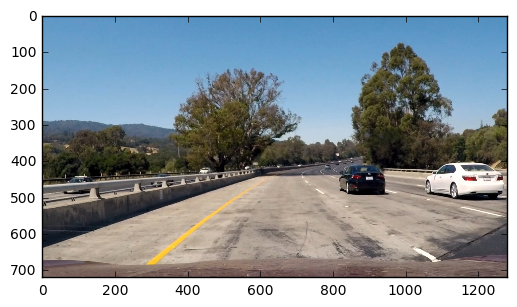

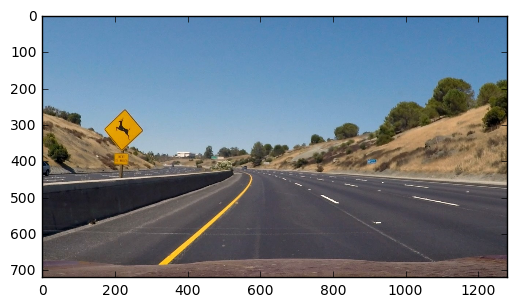

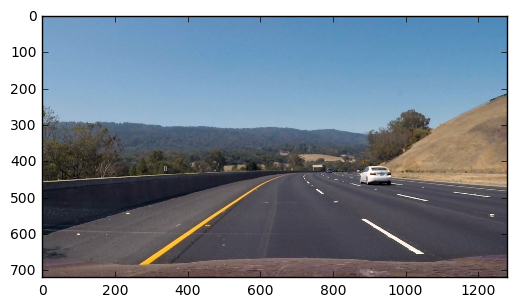

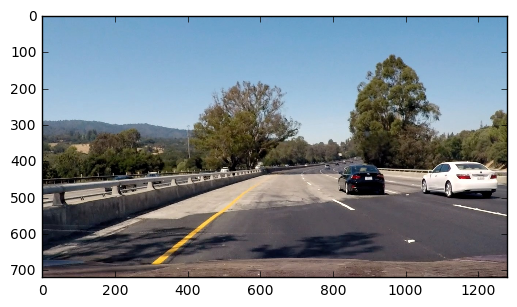

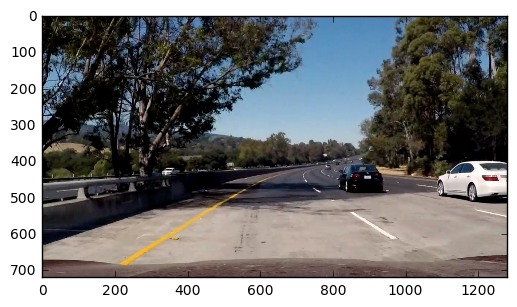

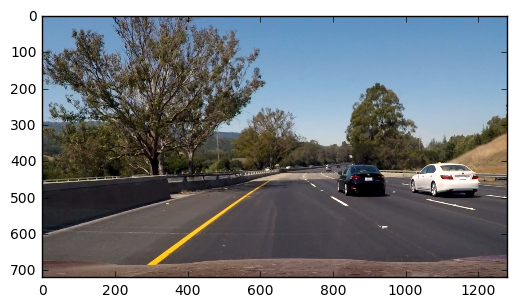

In [8]:
import os
images = []
for i in os.listdir('test_images'):
    img_path = 'test_images/' + i
    img = mpimg.imread(img_path)
    images.append(img)

for idx,image in enumerate(images):
    
    plt.figure(idx)
    plt.imshow(image)